## Defining a Data-Driven Domain of Shapes

**Input to define domain**:

- Dataset of 2D shapes (cross sections)
- Dependencies detailed below

In [1]:
# Python
import os
import numpy as np

# G2Aero
from g2aero import PGA
from g2aero import Grassmann as gr

# plotting routines
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Read airfoils data from data subdirectory

In [2]:
shapes_folder  = os.path.join(os.getcwd(), '../../data/airfoils/', )
#shapes = np.load(os.path.join(shapes_folder, 'shapes.npz'))['shapes']
shapes = np.load(os.path.join(shapes_folder, 'CST_shapes_TE_gap.npz'))['shapes']
print("Dataset:")
print(f"Shape of data = {shapes.shape}")
print(f"N shapes = {shapes.shape[0]}")
print(f"n landmarks in every shape = {shapes.shape[1]}")

Dataset:
Shape of data = (13000, 401, 2)
N shapes = 13000
n landmarks in every shape = 401


### Build PGA space and get coordinates 

In [3]:
# compute Karcher mean and run PGA to define coordinates
pga, t = PGA.PGAspace.create_from_dataset(shapes)

Karcher mean convergence:
||V||_F = 0.10235806971182138
||V||_F = 0.00015526889897758003
||V||_F = 2.7114758181406616e-07
||V||_F = 5.985411586299064e-10


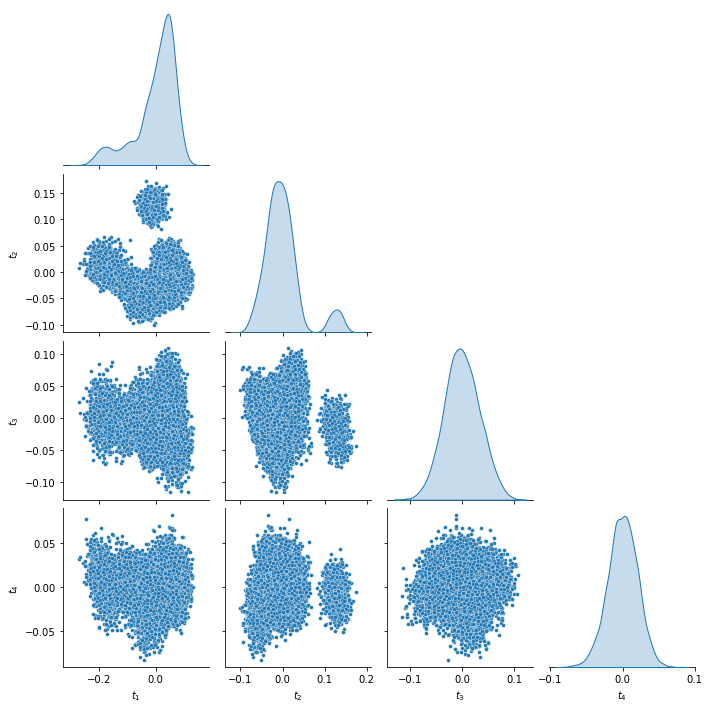

In [4]:
coord_names = ['$t_1$', '$t_2$', '$t_3$', '$t_4$']
df_all = pd.DataFrame(data=t[:, :4], columns=coord_names)
sns_plot = sns.pairplot(df_all, x_vars=coord_names, y_vars=coord_names,
                        diag_kind='kde', corner=True, plot_kws=dict(s=15))

### Let's reconstruct a low-dimensional shape and compare it to the original

Grassmannian distance: 0.03607142623675289
Worst-case Euclidean error: 0.004075096848161961


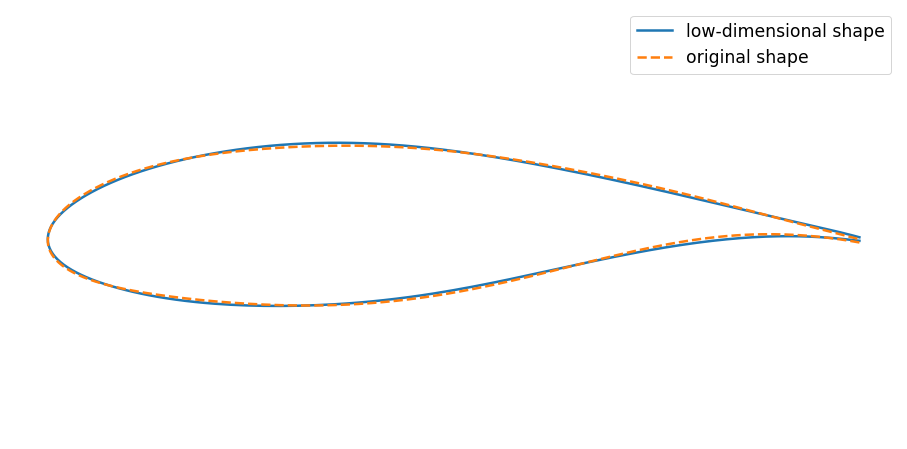

In [5]:
def norm_inf2(sh1, sh2):
    d = np.max(np.linalg.norm(sh1-sh2, ord=2, axis=1))
    return d

# save LA standardized shapes
data = PGA.Dataset(shapes)

# assign number of landmarks and total number of shapes
n_landmarks = shapes.shape[1]
N_shapes = shapes.shape[0]

# assign r as the dimension of the PGA shape
r = 4 # should always be less than or equal to 2*(n_landmarks - 2)
# pick a shape based on index from the dataset
j=1 # should be less than or equal to N_shapes-1

shape_new = PGA.perturb_gr_shape(pga.Vh, pga.karcher_mean, t[j,:r])
# match the shapes in the plane
R = gr.procrustes(shape_new, data.shapes_gr[j])
shape_new = shape_new @ R
# transform to matching physical scales
phys_shape = shape_new @ data.M[j] + data.b[j]

# comppute Grassmannian distance error
err_gr = PGA.distance(shape_new, data.shapes_gr[j])
print(f'Grassmannian distance: {err_gr}')

# compute worst-case Euclidean error in row-wise landmarks
err_inf2 = norm_inf2(phys_shape, shapes[j])
print(f'Worst-case Euclidean error: {err_inf2}')

# plot the low-dimensional shape and the original shape
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.plot(phys_shape[:,0], phys_shape[:,1],linewidth=2.5, label='low-dimensional shape')
plt.plot(shapes[j,:,0], shapes[j,:,1],'--',linewidth=2.5, label='original shape')
# formatting
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='xx-large')